<a href="https://colab.research.google.com/github/PTRRupprecht/CascadeTorch/blob/master/Demo%20scripts/Calibrated_spike_inference_with_Cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CascadeTorch

## Calibrated spike inference from calcium imaging data using deep networks
This is a branch of CASCADE which uses Torch instead of Tensorflow as the main deep learning-framework. Maintained by [Peter Rupprecht](https://github.com/PTRRupprecht).
The project was started by Peter as a collaboration of the [Helmchen Lab](https://www.hifo.uzh.ch/en/research/helmchen.html) and the [Friedrich Lab](https://www.fmi.ch/research-groups/groupleader.html?group=119). Feedback goes to [Peter Rupprecht](mailto:p.t.r.rupprecht+cascade@gmail.com).

---



This colaboratory notebook runs on servers in the cloud. It uses an algorithm based on deep networks for spike inference (CASCADE, described in this **[Resource Article](https://www.nature.com/articles/s41593-021-00895-5)** published in Nature Neuroscience). Here, you can test the algorithm and use it without any installation on your computer. You just have to sequentially **press the play buttons ("Run cell")** on the left of each box, and the code will be executed.

* If you want to **see the algorithm in action**, just execute the cells without any modifications. Enjoy!

* If you want to **upload your own data**, make predictions and download the saved files, you have to modify the variable names and follow the instructions. Usually no or very little modifications of the code is required.

* If you want to integrate CASCADE into **your local data analysis pipeline**, we suggest you take a look at the [Github repository](https://github.com/HelmchenLabSoftware/Calibrated-inference-of-spiking).


Let's get started!

##1. Download repository into the Colab Notebook


In [3]:
#@markdown The Github repository (CascadeTorch) with all custom functions, the ground truth datasets and the pretrained models is copied to the environment of this notebook. This will take a couple of seconds.

#@markdown *Note: You can check the code underlying each cell by double-clicking on it.*

import os

# If in Colab and not yet downloaded, download GitHub repository and change working directory
if os.getcwd() == '/content':
    !git clone https://github.com/PTRRupprecht/CascadeTorch
    os.chdir('CascadeTorch')

# If executed as jupyter notebook on own computer, change to parent directory for imports
if os.path.basename( os.getcwd() ) == 'Demo scripts':
    %cd ..
    print('New working directory:', os.getcwd() )

fatal: destination path 'CascadeTorch' already exists and is not an empty directory.


##2. Import required python packages


In [4]:
#@markdown Downloads packages from public repository, and packages from Cascade.

%%capture
!pip install ruamel.yaml

# standard python packages
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth
import torch

##3. Define the function to load ΔF/F traces


In [5]:
#@markdown ΔF/F traces must be saved as \*.npy-files (for Python) or \*.mat-files (for Matlab/Python) as a single large matrix named **`dF_traces`** (neurons x time). ΔF/F values of the input should be numeric, not in percent (e.g. 0.5 instead of 50%). For different input formats, the code in this box can be modified (it\'s not difficult).

def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""

    if file_path.endswith('.mat'):
      traces = sio.loadmat(file_path)['dF_traces']
      # PLEASE NOTE: If you use mat73 to load large *.mat-file, be aware of potential numerical errors, see issue #67 (https://github.com/HelmchenLabSoftware/Cascade/issues/67)

    elif file_path.endswith('.npy'):
      traces = np.load(file_path, allow_pickle=True)
      # if saved data was a dictionary packed into a numpy array (MATLAB style): unpack
      if traces.shape == ():
        traces = traces.item()['dF_traces']

    else:
      raise Exception('This function only supports .mat or .npy files.')

    print('Traces standard deviation:', np.nanmean(np.nanstd(traces,axis=1)))
    if np.nanmedian(np.nanstd(traces,axis=1)) > 2:
      print('Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.')
      return traces/100
    else:
        return traces





##4. Select dataset, indicate frame rate and load ΔF/F traces

In [6]:
#@markdown If you are testing the script, you can leave everything unchanged. If you want to apply the algorithm to your own data, you have to upload your data first. The paragraph above tells you how to format and name the file. You can do this by clicking on the **folder symbol ("Files")** on the left side of the Colaboratory notebook. Next, indicate the path of the uploaded file in the variable **`example_file`**. Finally, indicate the sampling rate of your recordings in the variable **`frame_rate`**.

example_file = "Example_datasets/Allen-Brain-Observatory-Visual-Coding-30Hz/Experiment_552195520_excerpt.mat" #@param {type:"string"}

frame_rate = 30 #@param {type:"number"}

try:

  traces = load_neurons_x_time( example_file )
  print('Number of neurons in dataset:', traces.shape[0])
  print('Number of timepoints in dataset:', traces.shape[1])

except Exception as e:

  print('\nSomething went wrong!\nEither the target file is missing, in this case please provide the correct location.\nOr your file is not yet completely uploaded, in this case wait until the upload is completed.\n')

  print('Error message: '+str(e))


Traces standard deviation: 0.079336
Number of neurons in dataset: 74
Number of timepoints in dataset: 6001


##5. Plot distribution of noise levels

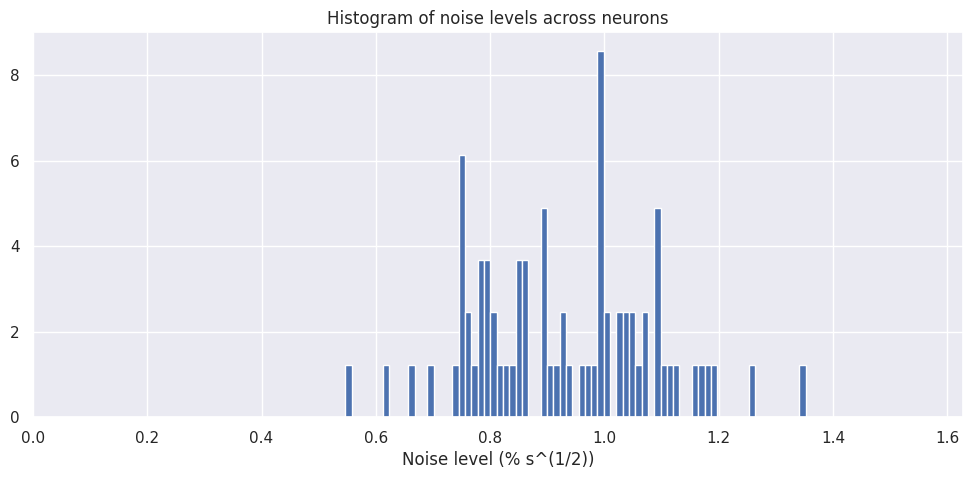

In [7]:
#@markdown For each neuron in the loaded dataset, the noise level will be computed and the distribution across neurons will be shown.
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 5]

noise_levels = plot_noise_level_distribution(traces,frame_rate)



##6. Plot randomly selected calcium traces

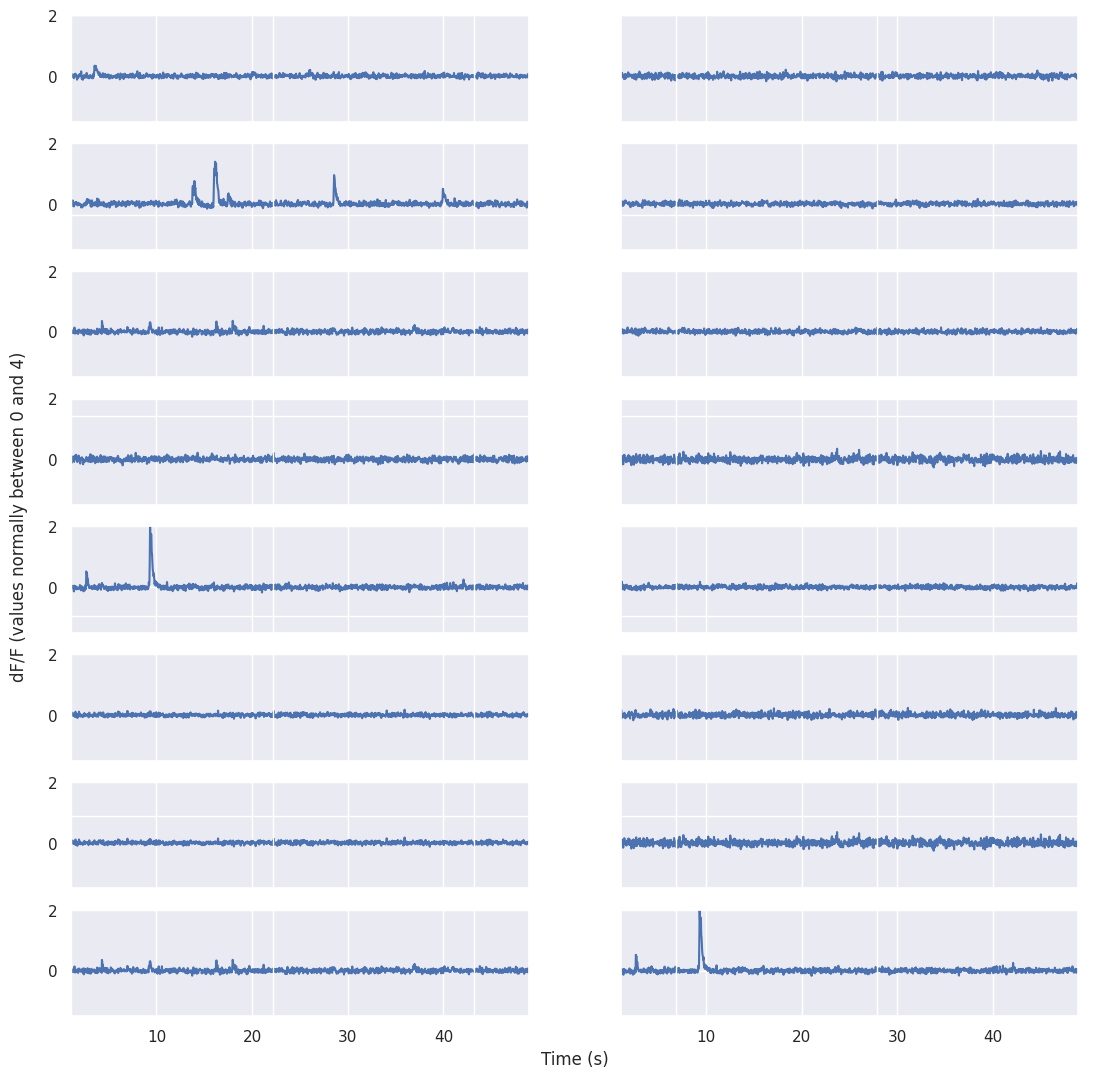

In [8]:
#@markdown Plotting random traces helps to check whether the data have been loaded correctly. If you want to plot specific instead of randomly selected neurons, modify the variable **`neuron_indices`** accordingly.


plt.rcParams['figure.figsize'] = [13, 13]

#np.random.seed(3952)
neuron_indices = np.random.randint(traces.shape[0], size=16)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate)




##7. Select pretrained model

In [10]:
#@markdown Get list of the names of available models.


cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models_CascadeTorch.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models_CascadeTorch.yaml file for valid model names.
File location: /content/CascadeTorch/Pretrained_models/available_models_CascadeTorch.yaml

 List of available models: 

GC8f_EXC_100Hz_smoothing10ms
GC8f_EXC_15Hz_smoothing100ms_high_noise
GC8f_EXC_15Hz_smoothing50ms_high_noise
GC8f_EXC_30Hz_smoothing25ms_high_noise
GC8f_EXC_30Hz_smoothing50ms_high_noise
GC8f_EXC_7.5Hz_smoothing100ms_high_noise
GC8f_EXC_7.5Hz_smoothing200ms_high_noise
GC8m_EXC_15Hz_smoothing100ms_high_noise
GC8m_EXC_15Hz_smoothing50ms_high_noise
GC8m_EXC_30Hz_smoothing25ms_high_noise
GC8m_EXC_30Hz_smoothing50ms_high_noise
GC8m_EXC_7.5Hz_smoothing100ms_high_noise
GC8m_EXC_7.5Hz_smoothing200ms_high_noise
GC8s_EXC_15Hz_smoothing100ms_high_noise
GC8s_EXC_15Hz_smoothing50ms_high_noise
GC8s_EXC_20Hz_smoothing30ms_high_noise
GC8s_EXC_20Hz_smoothing60ms_high_noise
GC8s_EXC_30Hz_smoothing25ms_high_noise
GC8s_EXC_30Hz_smoothing50ms_high_noise
GC8s_EXC_3Hz_smoothing250ms_high_noise
GC8s_E

In [11]:

#@markdown Select (from the list above) and download the model that fits to your dataset (frame rate, training data; see FAQ for more details) and assign to variable **`model_name`**.

model_name = "Global_EXC_30Hz_smoothing25ms" #@param {type:"string"}

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/content/CascadeTorch/Pretrained_models/Global_EXC_30Hz_smoothing25ms"


##8. Predict spike rates from ΔF/F traces

In [12]:
#@markdown If this takes too long, make sure that the GPU runtime is activated (*Menu > Runtime > Change Runtime Type*).

total_array_size = traces.itemsize*traces.size*64/1e9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If the expected array size is too large for the Colab Notebook, split up for processing
if total_array_size < 1:
  spike_prob = cascade.predict( model_name, traces, device=device, verbosity=1 )

# Will only be use for large input arrays (long recordings or many neurons)
else:

  print("Split analysis into chunks in order to fit into Colab memory.")

  # pre-allocate array for results
  spike_prob = np.zeros((traces.shape))
  # nb of neurons and nb of chuncks
  nb_neurons = traces.shape[0]
  nb_chunks = int(np.ceil(total_array_size/1))

  chunks = np.array_split(range(nb_neurons), nb_chunks)
  # infer spike rates independently for each chunk
  for part_array in range(nb_chunks):
    spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:], device=device )



 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a Gaussian kernel of a standard deviation of 25 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 74 neurons and 6001 frames.
Noise levels (mean, std; in standard units): 0.93, 0.17

Predictions for noise level 2:
	... ensemble 0
	... ensemble 1
	... ensemble 2
	... ensemble 3
	... ensemble 4

Predictions for noise level 3:
	No neurons for this noise level

Predictions for noise level 4:
	No neurons for this noise level

Predictions for noise level 5:
	No neurons for this noise level

Predictions for noise level 6:
	No neurons for this noise level

Predictions for noise level 7:
	No neurons for this noise level

Predictions for noise level 8:
	No neurons for this noise level

Predictions for noise level 9:
	No neurons for this noise level
Spike rate inference done.


##9. Plot randomly selected example predictions

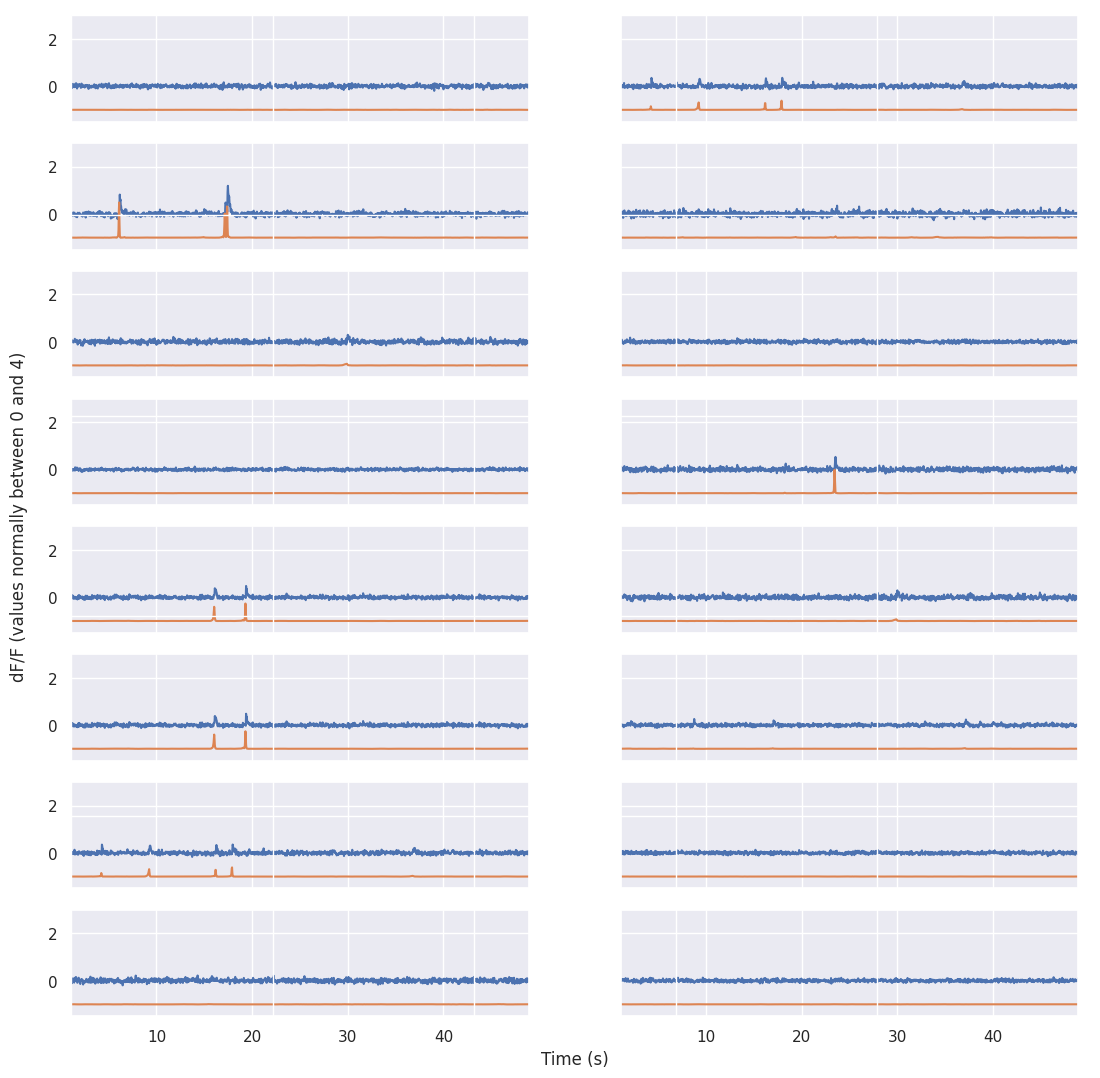

In [13]:
#@markdown By default plots a set of 16 randomly chosen neuronal traces (first seconds). The dF/F traces are shown in blue, the inferred spike probability is plotted in orange (shifted downwards by 1 for better visibility).

nb_neurons = 16

neuron_indices = np.random.randint(traces.shape[0], size=nb_neurons)
time_axis = plot_dFF_traces(traces,neuron_indices,frame_rate,spike_prob,y_range=(-1.5, 3))

##10. Save predictions to output file

In [14]:
#@markdown By default saves as variable **`spike_prob`** both to a *.mat-file and a *.npy-file. You can uncomment the file format that you do not need or leave it as it is.

folder = os.path.dirname(example_file)
file_name = 'predictions_' + os.path.splitext( os.path.basename(example_file))[0]
save_path = os.path.join(folder, file_name)

# save as mat file
sio.savemat(save_path+'.mat', {'spike_prob':spike_prob})

# save as numpy file
np.save(save_path, spike_prob)
